In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils.metric import evaluate
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score, pairwise_distances
from tqdm import tqdm
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.cm import ScalarMappable

import os
import sklearn
# help(sklearn.discriminant_analysis)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def read_data(pkl_path, loc):
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    pos_data, neg_data = [], []
    for d in data:
        if d['label'] == 0:
            pos_data.append(d[loc])
        else:
            neg_data.append(d[loc])
    if len(pos_data) == 0:
        pos_data = torch.empty(0)
    else:
        pos_data = torch.stack(pos_data).float()
    
    if len(neg_data) == 0:
        neg_data = torch.empty(0)
    else:
        neg_data = torch.stack(neg_data).float()
    # assert pos_data.shape[0] == neg_data.shape[0]
    return pos_data, neg_data

def read_data_all(pkl_path):
    with open(pkl_path, 'rb') as file:
        data = pickle.load(file)
    pos_data, neg_data = [], []
    for d in data:
        if d['label'] == 0:
            pos_data.append(d)
        else:
            neg_data.append(d)
    return pos_data, neg_data

def mix_data_fitting(x_train, y_train, model_name='lr'):
    model_list = []
    for head in range(x_train.shape[1]): # 32 * 32 = 1024
        if model_name == 'lda':
            model = LinearDiscriminantAnalysis(store_covariance=True)
        elif model_name == 'lr':
            model = LogisticRegression(penalty='l2')
        elif model_name == 'sgd':
            model = SGDClassifier(loss='log_loss')
        else:
            raise NotImplementedError
        model.fit(x_train[:, head], y_train)
        model_list.append(model)
    return model_list

def evaluation(x_val, y_val, model_list, shot=0, threshold=0.5):
    accs_mlp, asrs_mlp, prs_mlp, f1s_mlp, auroc_mlp = [], [], [], [], []
    matrixes = []
    for layer, model in enumerate(model_list):
        x_l = x_val[:, layer]
        y_l = y_val
        if shot > 0:
            model.partial_fit(x_val[:shot, layer], y_val[:shot], classes=[0,1])
            x_l = x_val[shot:, layer]
            y_l = y_val[shot:]
        y_pred = model.predict_proba(x_l)[:, 1]
        # acc, asr, pr, f1, auroc, neg_per_sample_result, pos_per_sample_result = \
        #     evaluate(y_l, y_pred, show=False, threshold=threshold, enable_analyse=True)
        acc, asr, pr, f1, auroc, matrix = \
            evaluate(y_l, y_pred, show=False, threshold=threshold)
        matrixes.append(matrix)
        accs_mlp.append(acc)
        asrs_mlp.append(asr)
        prs_mlp.append(pr)
        f1s_mlp.append(f1)
        auroc_mlp.append(auroc)
    return accs_mlp, asrs_mlp, prs_mlp, f1s_mlp, auroc_mlp, y_pred, matrixes


In [ ]:
def train_val_split(pos_data, neg_data, num_shot=10):
    total_num = pos_data.shape[0]
    train_num = int(num_shot) if num_shot != -1 else total_num
    val_num = total_num - train_num
    train_idx = random.sample(range(total_num), train_num)
    val_idx = list(set(range(total_num)) - set(train_idx))

    x_train = torch.cat([pos_data[train_idx], neg_data[train_idx]], dim=0)
    y_train = torch.cat([torch.zeros(train_num), torch.ones(train_num)])
    x_val = torch.cat([pos_data[val_idx], neg_data[val_idx]], dim=0)
    y_val = torch.cat([torch.zeros(val_num), torch.ones(val_num)])

    return x_train, y_train, x_val, y_val

def get_safety_heads_activation(data, top_k_indices):
    layer_idx = top_k_indices[:, 0]
    head_idx = top_k_indices[:, 1]
    activations = data[:, layer_idx, head_idx]
    return activations.reshape(data.shape[0], 1, -1)

def few_shot_probing(pos_data, neg_data, num_shot, num_repeat=10, threshold=0.5, model_name='lr'):
    model_list = []
    accs, asrs, prs, f1s, aurocs = [], [], [], [], []
    kappas, alphas= [], []
    matrixes = []
    for _ in tqdm(range(num_repeat)):
        if len(pos_data.shape) > 3:   # 'attn_headas'
            n, nl, nh, dh = pos_data.shape
            pos_data, neg_data = pos_data.reshape(n, -1, dh), neg_data.reshape(n, -1, dh) # 按head数创建model
        x_train, y_train, x_val, y_val = train_val_split(pos_data, neg_data, num_shot=num_shot)
        # [num_shot, 1024, 128]
        models = mix_data_fitting(x_train, y_train, model_name=model_name)
        if model_name == 'lda':
            heads_kappa, heads_alpha = [], []
            # print(x_val.shape, y_val.shape, y_val==0)
            x_pos = x_val[y_val == 0, :, :]
            x_neg = x_val[y_val == 1, :, :]
            for head in range(x_val.shape[1]):
                w = models[0].coef_.flatten() # (128,)
                x_pos_head = x_pos[:, head, :]
                x_neg_head = x_neg[:, head, :]
                # print(x_pos_head.shape)
                
                u_pos = torch.mean(x_pos_head, axis=0)
                u_neg = torch.mean(x_neg_head, axis=0)

                cov_pos = np.cov(x_pos_head, rowvar=False)
                cov_neg = np.cov(x_neg_head, rowvar=False)

                numerator = np.abs(np.dot(w.T, u_pos - u_neg))  # 分子部分
                denominator = np.sqrt(np.dot(np.dot(w.T, cov_pos), w)) + np.sqrt(np.dot(np.dot(w.T, cov_neg), w))  # 分母部分
                kappa = numerator / denominator  # 最终的kappa值
                
                alpha = kappa**2 / (1+kappa**2)
                heads_kappa.append(kappa)
                heads_alpha.append(alpha)
            kappas.append(heads_kappa)
            alphas.append(heads_alpha)

        model_list.append(models)
        accs_mlp, asrs_mlp, prs_mlp, f1s_mlp, auroc_mlp, y_pred, matrix = evaluation(x_val, y_val, models,  threshold=threshold)
        matrixes.append(matrix)
        accs.append(accs_mlp)
        asrs.append(asrs_mlp)
        prs.append(prs_mlp)
        f1s.append(f1s_mlp)
        aurocs.append(auroc_mlp)

    return {
        'acc': np.array(accs),
        'asr': np.array(asrs),
        'pr': np.array(prs),
        'f1': np.array(f1s),
        'auroc': np.array(aurocs),
        'pred': y_pred,
        'threshold': threshold,
        'kappa': np.array(kappas),
        'alpha': np.array(alphas),
        'matrixes': matrixes
    }, model_list

def testing(test_data, labels, model_list, shot=0, threshold=0.5):
    accs, asrs, prs, f1s, aurocs = [], [], [], [], []
    matrixes = []
    for models in tqdm(model_list):
        if len(test_data.shape) > 3:   # 'attn_headas'
            n, nl, nh, dh = test_data.shape
            test_data = test_data.reshape(n, -1, dh)
        x_val = test_data
        y_val = labels
        accs_mlp, asrs_mlp, prs_mlp, f1s_mlp, auroc_mlp, y_pred, matrix = evaluation(x_val, y_val, models, shot=shot, threshold=threshold)
        matrixes.append(matrix)
        accs.append(accs_mlp)
        asrs.append(asrs_mlp)
        prs.append(prs_mlp)
        f1s.append(f1s_mlp)
        aurocs.append(auroc_mlp)
    return {
        'acc': np.array(accs),
        'asr': np.array(asrs),
        'pr': np.array(prs),
        'f1': np.array(f1s),
        'auroc': np.array(aurocs),
        'pred': y_pred,
        'threshold': threshold,
        'matrixes':matrixes
    }

def plot_avg_confusion_matrix(matrixes):
    flat_matrixes = [tuple_4 for [tuple_4] in matrixes]
    # (N, 4)
    matrix_array = np.array(flat_matrixes)

    if matrix_array.shape[1] != 4:
        raise ValueError("(TP, FN, FP, TN)")

    avg_tp, avg_fn, avg_fp, avg_tn = matrix_array.mean(axis=0)

    conf_matrix = np.array([
        [avg_tp, avg_fn],  
        [avg_fp, avg_tn]   
    ])

    plt.figure(figsize=(3, 3))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["Pred 1", "Pred 0"], yticklabels=["True 1", "True 0"])
    plt.title("Average Confusion Matrix (Row-normalization)")
    plt.xlabel("Prediction")
    plt.ylabel("GT")
    plt.tight_layout()
    plt.show()


# MMSafety

In [3]:
pos_data_train_all, neg_data_train_all = read_data_all('output_old/LLaVA-7B/raw_mmsafety_train_all_oe_activations.pkl')
pos_data_train, neg_data_train = torch.stack([d['attn_heads'] for d in pos_data_train_all]), torch.stack([d['attn_heads'] for d in neg_data_train_all])
pos_data_train_all[0].keys(), pos_data_train.shape, neg_data_train.shape

(dict_keys(['image', 'img_path', 'model_name', 'question', 'answer', 'label', 'attn_residual', 'hidden_states', 'mlp_residual', 'attn_heads', 'vit_attn_heads', 'hidden_states_mean']),
 torch.Size([252, 32, 32, 128]),
 torch.Size([252, 32, 32, 128]))

In [4]:
pos_data_train, neg_data_train = read_data('output/LLaVA-7B/raw_mmsafety_train_all_oe_activations.pkl', loc='attn_heads')
pos_data_test, neg_data_test = read_data('output/LLaVA-7B/raw_mmsafety_test_all_oe_activations.pkl', loc='attn_heads')
# pos_data_train, neg_data_train = read_data('output/Qwen-VL-Chat/raw_mmsafety_train_all_oe_activations.pkl', loc='attn_heads')
# pos_data_test, neg_data_test = read_data('output/Qwen-VL-Chat/raw_mmsafety_test_all_oe_activations.pkl', loc='attn_heads')
pos_data_train.shape, pos_data_test.shape

(torch.Size([252, 32, 32, 128]), torch.Size([1548, 32, 32, 128]))

### locate(1/2) probe each head `metrics_mmsafety['acc']`

In [11]:
def plot_heatmap(metrics_mmsafety, save_path=None):
    from matplotlib.colors import LinearSegmentedColormap
    mean = metrics_mmsafety['alpha'].mean(0).reshape(32, 32)
    normalized_mean = (mean - mean.min()) / (mean.max() - mean.min())
    colors = ["#ffffff","#ffb72c"]
    custom_cmap = LinearSegmentedColormap.from_list("custom", colors)
    # 128/1024 heads
    sns.heatmap(normalized_mean.T, vmin=np.quantile(normalized_mean, 0.875), vmax=normalized_mean.max(), linewidths=0.5, cmap=custom_cmap)
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, format='pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

In [10]:
metrics_mmsafety, _ = few_shot_probing(pos_data_train, neg_data_train, num_shot=17, num_repeat=20, model_name='lda')

100%|██████████| 20/20 [04:08<00:00, 12.40s/it]


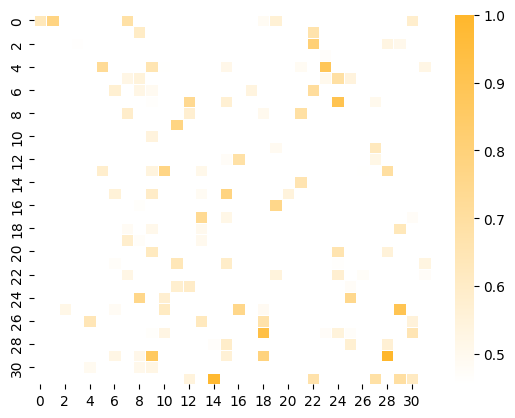

In [12]:
heatmap_name = "raw_figs/875/llava-17shot-heatmap.pdf"
plot_heatmap(metrics_mmsafety, heatmap_name)

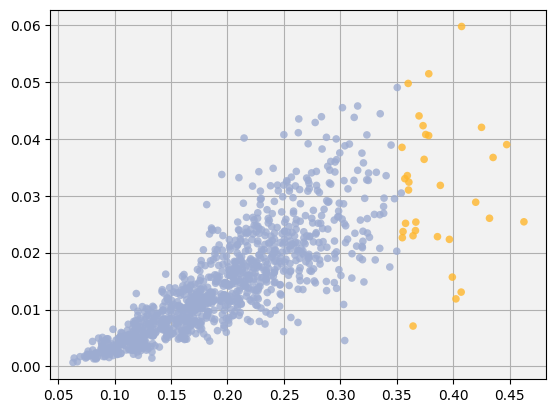

In [13]:
distribution_name = "raw_figs/distribution/llava-17shot-alpha-var.pdf"
x, y = metrics_mmsafety['kappa'].mean(0), metrics_mmsafety['kappa'].var(0) # 'alpha' 'kappa' 'acc'
top_indices = np.argsort(x)[-32:]
colors = ['#ffb72c' if i in top_indices else '#9dacd1' for i in range(len(x))]
plt.scatter(x+0.02, y, s=30, alpha=0.8, edgecolor='none', c=colors, zorder=2)
# plt.title('1% Probes for Each Attention Head')
# plt.xlabel('Mean Accuracy (%)')
# plt.ylabel('Variance')
# plt.ylim(0,1e-35)
# plt.xlim(0.45)
plt.gca().set_facecolor('#F2F2F2')
plt.grid(zorder=1)
os.makedirs(os.path.dirname(distribution_name), exist_ok=True)
plt.savefig(distribution_name, format='pdf', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

### locate(2/2) `top_k_indices` and $Acc_k$

In [14]:
metrics_mmsafety, _ = few_shot_probing(pos_data_train, neg_data_train, num_shot=20, num_repeat=20, model_name='lda')

100%|██████████| 20/20 [04:10<00:00, 12.51s/it]


In [15]:
# 1. calculate average accuracy
top_k = 32
top_k_indices_flat = np.argsort(metrics_mmsafety['alpha'].mean(0))[-top_k:][::-1]
top_k_indices = np.array(np.unravel_index(top_k_indices_flat, (32, 32))).T
np.sort(metrics_mmsafety['acc'].mean(0))[-top_k:].mean() # 返回数组的值 取平均

0.8262055495689656

In [16]:
# 2. get the indices for plotting tsne
for i, ind in enumerate(top_k_indices):
    print(f'top{i+1}: layer {ind[0]} head {ind[1]}')
top_k_indices_flat[np.lexsort((top_k_indices[:, 1], top_k_indices[:, 0]))], top_k_indices[np.lexsort((top_k_indices[:, 1], top_k_indices[:, 0]))]

top1: layer 18 head 27
top2: layer 28 head 29
top3: layer 4 head 30
top4: layer 23 head 4
top5: layer 18 head 29
top6: layer 7 head 14
top7: layer 9 head 20
top8: layer 27 head 31
top9: layer 29 head 25
top10: layer 9 head 29
top11: layer 18 head 26
top12: layer 14 head 31
top13: layer 1 head 0
top14: layer 23 head 27
top15: layer 9 head 27
top16: layer 16 head 12
top17: layer 7 head 1
top18: layer 10 head 25
top19: layer 22 head 6
top20: layer 5 head 4
top21: layer 16 head 25
top22: layer 7 head 28
top23: layer 19 head 30
top24: layer 12 head 31
top25: layer 9 head 15
top26: layer 9 head 18
top27: layer 19 head 0
top28: layer 21 head 8
top29: layer 10 head 10
top30: layer 10 head 31
top31: layer 13 head 26
top32: layer 22 head 1


(array([ 32, 158, 164, 225, 238, 252, 303, 306, 308, 315, 317, 330, 345,
        351, 415, 442, 479, 524, 537, 602, 603, 605, 608, 638, 680, 705,
        710, 740, 763, 895, 925, 953]),
 array([[ 1,  0],
        [ 4, 30],
        [ 5,  4],
        [ 7,  1],
        [ 7, 14],
        [ 7, 28],
        [ 9, 15],
        [ 9, 18],
        [ 9, 20],
        [ 9, 27],
        [ 9, 29],
        [10, 10],
        [10, 25],
        [10, 31],
        [12, 31],
        [13, 26],
        [14, 31],
        [16, 12],
        [16, 25],
        [18, 26],
        [18, 27],
        [18, 29],
        [19,  0],
        [19, 30],
        [21,  8],
        [22,  1],
        [22,  6],
        [23,  4],
        [23, 27],
        [27, 31],
        [28, 29],
        [29, 25]]))

### train

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


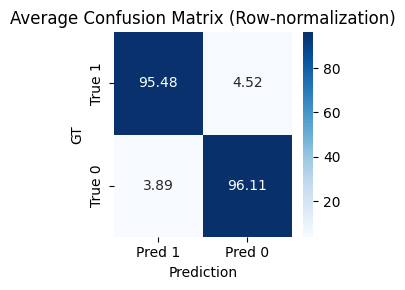

(4.523809523809524, 96.11111111111111, 95.79365079365078, 95.77563968354193)

In [17]:
# num_shot = int(pos_data_train.shape[0] / 3 * 2) * 0.5
num_shot = int(pos_data_train.shape[0] * 0.5)
num_repeat = 20
metrics, model_list_lda = few_shot_probing(get_safety_heads_activation(pos_data_train, top_k_indices), get_safety_heads_activation(neg_data_train, top_k_indices), num_shot=num_shot, num_repeat=num_repeat, model_name='lda')
plot_avg_confusion_matrix(metrics['matrixes'])
metrics['asr'].mean(), metrics['pr'].mean(), metrics['acc'].mean()*100, metrics['f1'].mean()*100

### LLaVA test

#### mmsafety in domain

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:01<00:00, 11.71it/s]


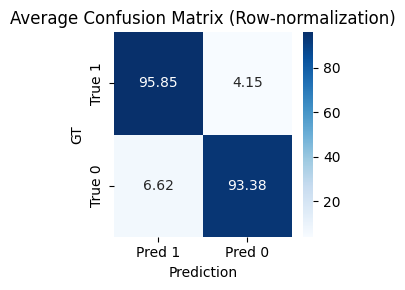

(4.145658263305323, 93.37855297157623, 94.56653225806451, 94.42233675589094)

In [18]:
# ind test
model_list = model_list_lda
metrics = testing(torch.cat([get_safety_heads_activation(pos_data_test, top_k_indices), get_safety_heads_activation(neg_data_test, top_k_indices)]), \
            torch.cat([torch.zeros(pos_data_test.shape[0]), torch.ones(neg_data_test.shape[0])]), model_list, threshold=0.5)
plot_avg_confusion_matrix(metrics['matrixes'])
metrics['asr'].mean(), metrics['pr'].mean(), metrics['acc'].mean()*100, metrics['f1'].mean()*100

In [19]:
metrics['acc'].mean(), metrics['acc'].var()

(0.9456653225806452, 2.0946017964504547e-05)

#### pred_json: for generation test on mmsafety

In [ ]:
import json
test_mmsafety = 'output/LLaVA-7B/raw_mmsafety_test_all_oe_activations.pkl'
json_path = './eval/mmsafety/llava/alpha_250623.json'
os.makedirs(os.path.dirname(json_path), exist_ok=True)
pos_data_test_all, neg_data_test_all = read_data_all(test_mmsafety)
# pos_data_test_all, neg_data_test_all = read_data_all('output/Qwen-VL-Chat/raw_mmsafety_test_all_oe_activations.pkl')
data = dict()
for i, d in enumerate(pos_data_test_all):
    data[d['img_path']] = int(metrics['pred'][i] > 0.5)
for i, d in enumerate(neg_data_test_all):
    data[d['img_path']] = int(metrics['pred'][i+len(pos_data_test_all)] > 0.5)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)

#### pred_json: for general test on mmvet

In [ ]:
pos_data_mmvet, neg_data_mmvet = read_data(test_mmvet, loc='attn_heads')
pos_data_mmvet.shape, neg_data_mmvet.shape

(torch.Size([218, 32, 32, 128]), torch.Size([0]))

In [28]:
import json
test_mmvet = '/workspace/safety_heads/Attack/output/LLaVA-7B/raw_mmvet__all_oe_activations.pkl'
json_path = './eval/mmvet/llava/mm32-seed0.json'
os.makedirs(os.path.dirname(json_path), exist_ok=True)
pos_data_test_mmvet, neg_data_test_mmvet = read_data_all(test_mmvet)
data = dict()
for i, d in enumerate(pos_data_test_mmvet):
    data[f'v1_{i}'] = int(metrics['pred'][i] > 0.5)
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(data, f, indent=4)

In [29]:
pos_data_train, neg_data_train = read_data('output/LLaVA-7B/raw_mmsafety_train_all_oe_activations.pkl', loc='attn_heads')
pos_data_test, neg_data_test = read_data('output/LLaVA-7B/raw_mmsafety_test_all_oe_activations.pkl', loc='attn_heads')
# pos_data_train, neg_data_train = read_data('output/Qwen-VL-Chat/raw_mmsafety_train_all_oe_activations.pkl', loc='attn_heads')
# pos_data_test, neg_data_test = read_data('output/Qwen-VL-Chat/raw_mmsafety_test_all_oe_activations.pkl', loc='attn_heads')
pos_data_train.shape, pos_data_test.shape

(torch.Size([252, 32, 32, 128]), torch.Size([1548, 32, 32, 128]))

In [34]:
metrics_mmsafety, _ = few_shot_probing(pos_data_train, neg_data_train, num_shot=20, num_repeat=20, model_name='lda')

100%|██████████| 20/20 [04:14<00:00, 12.74s/it]


In [35]:
top_k = 32
top_k_indices_flat_alpha = np.argsort(np.array(metrics_mmsafety['alpha']).mean(0))[-top_k:][::-1]
top_k_indices_alpha = np.array(np.unravel_index(top_k_indices_flat_alpha, (32, 32))).T
# np.sort(np.array(metrics_mmsafety['alpha']).mean(0))[-top_k:].mean() # 返回数组的值 取平均
np.array(metrics_mmsafety['acc'])[:, top_k_indices_flat_alpha].mean()

0.7648370150862069

100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


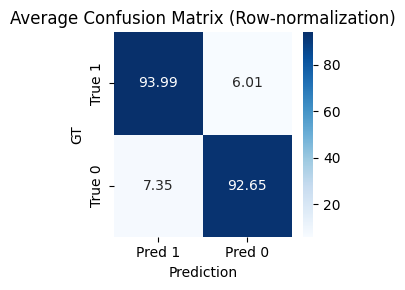

(6.011904761904762, 92.64880952380952, 93.3184523809524, 93.36864174319064)

In [ ]:
num_shot = int(pos_data_train.shape[0] / 3 * 2) * 0.5
# num_shot = int(pos_data_train.shape[0] * 0.5)
num_repeat = 20
metrics, model_list_lda_alpha = few_shot_probing(get_safety_heads_activation(pos_data_train, top_k_indices_alpha), get_safety_heads_activation(neg_data_train, top_k_indices_alpha), num_shot=num_shot, num_repeat=num_repeat, model_name='lda')
plot_avg_confusion_matrix(metrics['matrixes'])
metrics['asr'].mean(), metrics['pr'].mean(), metrics['acc'].mean()*100, metrics['f1'].mean()*100

### transfer

##### indomain

In [40]:
# pos_ind, neg_ind = read_data('/workspace/safety_heads/Attack/output_old/Qwen-VL-Chat/raw_mmsafety_SD_TYPO_all_oe_activations.pkl', loc='attn_heads')
metrics = testing(
    torch.cat([get_safety_heads_activation(pos_data_test, top_k_indices_alpha), get_safety_heads_activation(neg_data_test, top_k_indices_alpha)]),
    torch.cat([torch.zeros(pos_data_test.shape[0]), torch.ones(neg_data_test.shape[0])]), 
    model_list_lda_alpha
    )
metrics['acc'].mean(), metrics['acc'].var()

100%|██████████| 20/20 [00:01<00:00, 12.95it/s]


(0.9290826612903225, 4.516954407662744e-05)

##### indomain neg data std

In [43]:
metrics = testing(
    get_safety_heads_activation(neg_data_test, top_k_indices_alpha),
    torch.ones(neg_data_test.shape[0]), 
    model_list_lda_alpha
    )
metrics['acc'].mean(), metrics['acc'].var()

100%|██████████| 20/20 [00:01<00:00, 18.64it/s]


(0.9482142857142856, 0.00017882030263085646)

##### mmsafety --> vlguard

In [53]:
pos_ood, neg_ood = read_data('output/LLaVA-7B/raw_vlguard_train_all_oe_activations.pkl', loc='attn_heads')
# pos_ood, neg_ood = read_data('output/Qwen-VL-Chat/raw_vlguard_train_all_oe_activations.pkl', loc='attn_heads')
metrics = testing(
    torch.cat([get_safety_heads_activation(pos_ood, top_k_indices_alpha), get_safety_heads_activation(neg_ood, top_k_indices_alpha)]),
    torch.cat([torch.zeros(pos_ood.shape[0]), torch.ones(neg_ood.shape[0])]), 
    model_list_lda_alpha, 
    threshold=0.5
    )
metrics['acc'].mean(), metrics['acc'].var()

100%|██████████| 20/20 [00:00<00:00, 21.15it/s]


(0.759825997952917, 0.010429203827227878)

In [54]:
_, neg_ood = read_data('output_old/LLaVA-7B/raw_vlguard_test_all_oe_activations.pkl', loc='attn_heads')
# _, neg_ood = read_data('output/Qwen-VL-Chat/raw_vlguard_test_all_oe_activations.pkl', loc='attn_heads')
metrics = testing(get_safety_heads_activation(neg_ood, top_k_indices_alpha), torch.ones(neg_ood.shape[0]), model_list_lda_alpha, threshold=0.5)
# metrics = testing(get_safety_heads_activation(pos_ood, top_k_indices_alpha), torch.zeros(pos_ood.shape[0]), model_list_lda_alpha, threshold=0.5)
metrics['acc'].mean(), metrics['acc'].var()

100%|██████████| 20/20 [00:00<00:00, 78.31it/s]


(0.5745519713261649, 0.0428814506494007)

##### mmsafet --> vlsafe

In [55]:
with open('output_old/LLaVA-7B/raw_vlsafe_none_all_oe_activations.pkl', 'rb') as file:
# with open('output/Qwen-VL-Chat/raw_vlsafe_test_all_oe_activations.pkl', 'rb') as file:
    data = pickle.load(file)
neg_ood = [d['attn_heads'] for d in data]
neg_ood = torch.stack(neg_ood).float()

metrics = testing(get_safety_heads_activation(neg_ood, top_k_indices_alpha), torch.ones(neg_ood.shape[0]), model_list_lda_alpha, threshold=0.5)
metrics['acc'].mean(), metrics['acc'].var()

100%|██████████| 20/20 [00:00<00:00, 40.73it/s]


(0.9530630630630632, 0.0007048859670481293)